Data Shape: (525600, 19)
Columns:
 Index(['Timestamp', 'GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS',
       'WSgust', 'WSstdev', 'WD', 'WDstdev', 'BP', 'Cleaning', 'Precipitation',
       'TModA', 'TModB', 'Comments'],
      dtype='object')
Duplicate rows: 0
Timestamp range: 2021-10-25 00:01:00 to 2022-10-25 00:00:00
Data frequency (seconds):
 Timestamp
0 days 00:01:00    525599
Name: count, dtype: int64
Columns with >5% missing values:
 Comments    100.0
dtype: float64

Descriptive Statistics:
                            Timestamp            GHI            DNI  \
count                         525600  525600.000000  525600.000000   
mean   2022-04-25 12:00:30.000000768     230.555040     151.258469   
min              2021-10-25 00:01:00     -12.700000       0.000000   
25%              2022-01-24 06:00:45      -2.200000       0.000000   
50%              2022-04-25 12:00:30       2.100000       0.000000   
75%              2022-07-25 18:00:15     442.400000     246.400000  

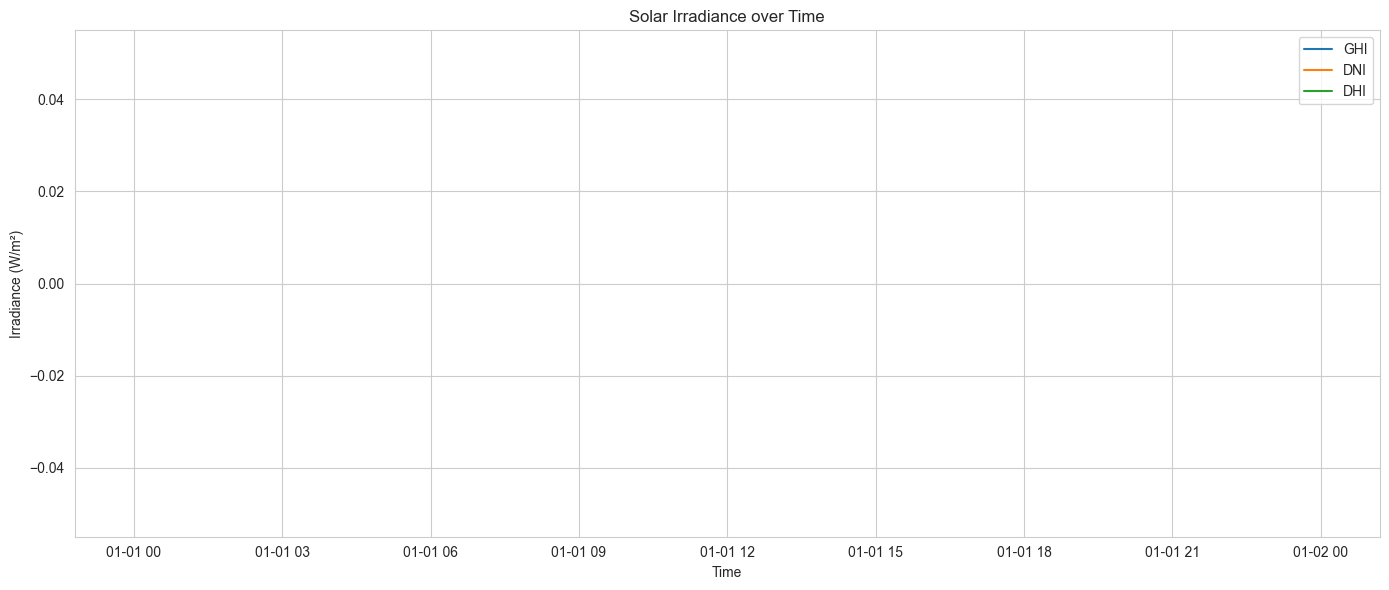

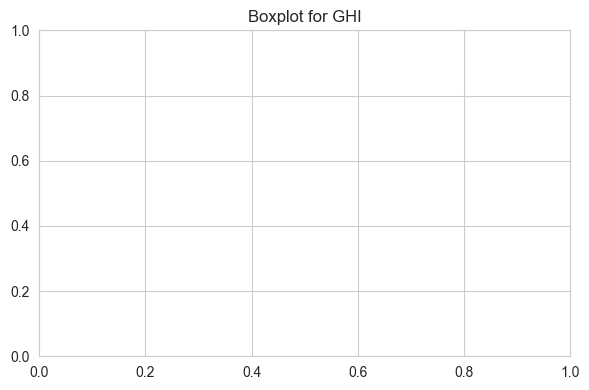

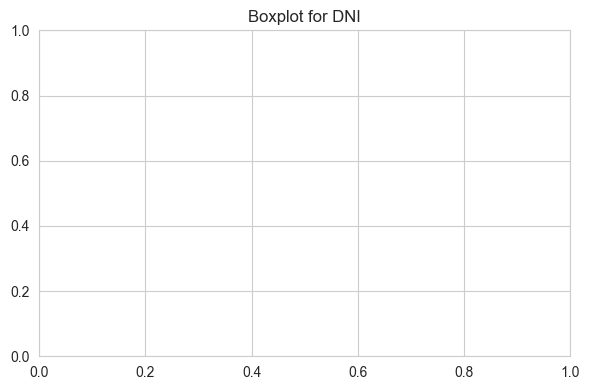

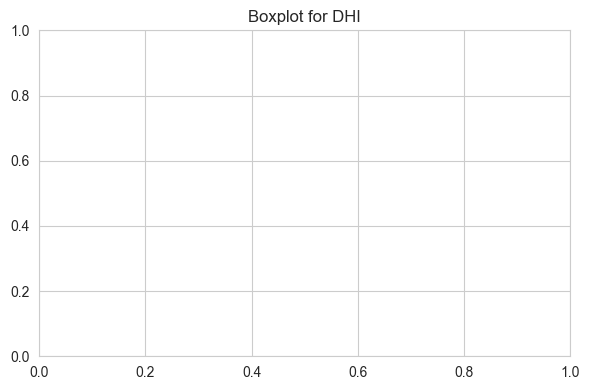

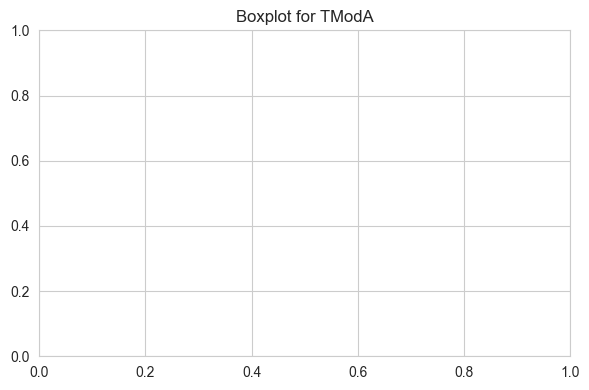

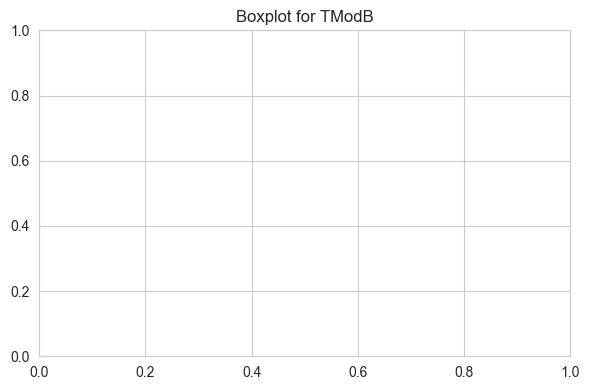

'Cleaning' column missing or contains only NaN. Skipping ModA/ModB analysis.


/Users/jerus/Desktop/KAIM/solar-challenge-week1/.venv/lib/python3.13/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/jerus/Desktop/KAIM/solar-challenge-week1/.venv/lib/python3.13/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


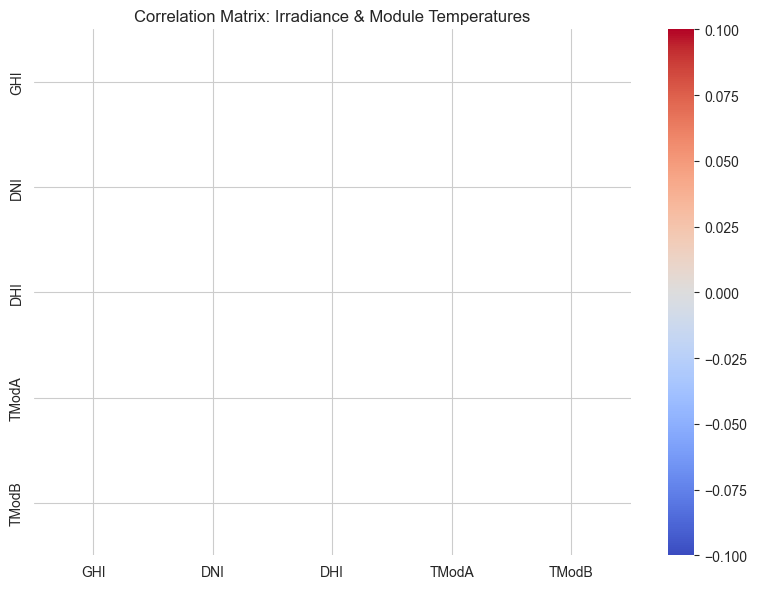


EDA completed on: 2025-05-20 16:32:11


In [1]:
# EDA for Solar Energy Dataset (Malanville, Benin)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Set seaborn style for plots
sns.set_style('whitegrid')



# Load dataset
file_path = '../data/togo-dapaong_qc.csv'
df = pd.read_csv(file_path, encoding='cp1252', parse_dates=['Timestamp'], low_memory=False)

# Display dataset shape and columns
print(f"Data Shape: {df.shape}")
print("Columns:\n", df.columns)

# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")

# Timestamp overview
print(f"Timestamp range: {df['Timestamp'].min()} to {df['Timestamp'].max()}")
print("Data frequency (seconds):\n", df['Timestamp'].diff().value_counts().head())

# Missing data check
missing_percent = df.isnull().mean() * 100
print("Columns with >5% missing values:\n", missing_percent[missing_percent > 5])

# Basic statistics
print("\nDescriptive Statistics:\n", df.describe())

# Outlier detection using Z-score
cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
subset = df[cols]

z_scores = np.abs(zscore(df[cols], nan_policy='omit'))
outliers = (z_scores > 3).sum(axis=1)
print(f"Number of rows with outliers in any column: {(outliers > 0).sum()}")

# Impute missing values using median
df[cols] = df[cols].apply(lambda x: x.fillna(x.median()))

# Drop rows with remaining missing values
df.dropna(inplace=True)
print(f"Data shape after cleaning: {df.shape}")

# Extract time features
df['Hour'] = df['Timestamp'].dt.hour
df['Month'] = df['Timestamp'].dt.month

# Line plot: Irradiance over time
plt.figure(figsize=(14, 6))
for col in ['GHI', 'DNI', 'DHI']:
    plt.plot(df['Timestamp'], df[col], label=col)
plt.title('Solar Irradiance over Time')
plt.xlabel('Time')
plt.ylabel('Irradiance (W/m²)')
plt.legend()
plt.tight_layout()
plt.show()

# Boxplots for outlier visualization
for col in cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot for {col}')
    plt.tight_layout()
    plt.show()

# Mean ModA and ModB by Cleaning status
if 'Cleaning' in df.columns and df['Cleaning'].notnull().any():
    grouped = df.groupby('Cleaning')[['ModA', 'ModB']].mean()
    if not grouped.empty:
        grouped.plot(kind='bar', figsize=(8, 5))
        plt.title('Average ModA & ModB by Cleaning Event')
        plt.ylabel('Module Output')
        plt.tight_layout()
        plt.show()
    else:
        print("Grouped data is empty. Skipping ModA/ModB plot.")
else:
    print("'Cleaning' column missing or contains only NaN. Skipping ModA/ModB analysis.")

# Correlation heatmap
plt.figure(figsize=(8, 6))
corr = df[['GHI', 'DNI', 'DHI', 'TModA', 'TModB']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix: Irradiance & Module Temperatures')
plt.tight_layout()
plt.show()

# Completion notice
print(f"\nEDA completed on: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
